# Model Fitting

*For saving some time we will apply preprocessing steps from previous modules (with additional discusions)*

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    roc_curve,
    precision_recall_curve,
    auc,
    ConfusionMatrixDisplay,
    confusion_matrix,
    classification_report,
)

In [2]:
nuemric = [
    "avg_days_to_buy_variant_id",
    "std_days_to_buy_variant_id",
    "avg_days_to_buy_product_type",
    "std_days_to_buy_product_type",
    "normalised_price",
    "discount_pct",
    "global_popularity",
]
ordinal = [
    "user_order_seq",
    "count_adults",
    "count_children",
    "count_babies",
    "count_pets",
    "people_ex_baby",
    "days_since_purchase_variant_id",
    "days_since_purchase_product_type",
]
binary = [
    "outcome",
    "ordered_before",
    "abandoned_before",
    "active_snoozed",
    "set_as_regular",
]
categrorical = ["product_type", "vendor"]
ides = ["order_id", "user_id", "variant_id"]
date = ["created_at", "order_date"]

def filter_orders(data: pd.DataFrame) -> pd.DataFrame:
    order_counts = (
        data.groupby("order_id")["outcome"].sum().reset_index(name="products_bought")
    )
    filtered_orders = order_counts[order_counts["products_bought"] >= 5]
    final_dataframe = data[data["order_id"].isin(filtered_orders["order_id"])]
    return final_dataframe

def data_load(
    path: str,
    nuemric: list,
    ordinal: list,
    binary: list,
    categrorical: list,
    ides: list,
    date: list,
) -> pd.DataFrame:
    cols = nuemric + ordinal + binary + categrorical + ides + date
    try:
        df = pd.read_csv(path, delimiter=',')
        if not set(cols).issubset(list(df.columns)):
            raise Exception("El DataFrame no contiene todas las columnas esperadas.")
        if df.empty:
            raise Exception("El DataFrame está vacío.")

        df[ordinal] = df[ordinal].astype(np.int8)
        df[binary] = df[binary].astype(np.int8)
        df[nuemric] = df[nuemric].astype(np.float64)
        df[date[0]] = pd.to_datetime(df[date[0]])
        df[date[1]] = pd.to_datetime(df[date[1]])
        df = filter_orders(data=df)

        if df.isnull().values.any():
            raise Exception("El DataFrame contiene valores nulos que hay que imputar.")
        return df

    except FileNotFoundError:
        print(f"Error: El archivo CSV no se encuentra en el path especificado: {path}")
    except pd.errors.EmptyDataError:
        print("Error: El archivo CSV está vacío.")
    except Exception as e:
        print(f"Error: {str(e)}")
    return None

data = data_load(
    path='../../data/feature_frame.csv',
    nuemric=nuemric,
    ordinal=ordinal,
    binary=binary,
    categrorical=categrorical,
    ides=ides,
    date=date,
)

In the previous module, a stratified data split was performed, but the temporal nature of the data was not taken into account. Now, we'll do a temporal split, but new issues arise. It's possible that the model might memorize forecasts of variables that depend on past information, leading to data leakage, such as the "ordered before" variable or the "global popularity" variable. We'll dive deeper into each of these problems.

# Split Considerations

In the graph, we can see the evolution of business orders. We already saw in the exploratory analysis that the business is growing, and we identified the regions where this growth is happening. Additionally, we observed that the average ticket ($) hasn't changed much over time. We want a model that can adapt to changes in customer behavior patterns, but with the available information, we can't make that inference. However, in this module, we will implement the temporal split.

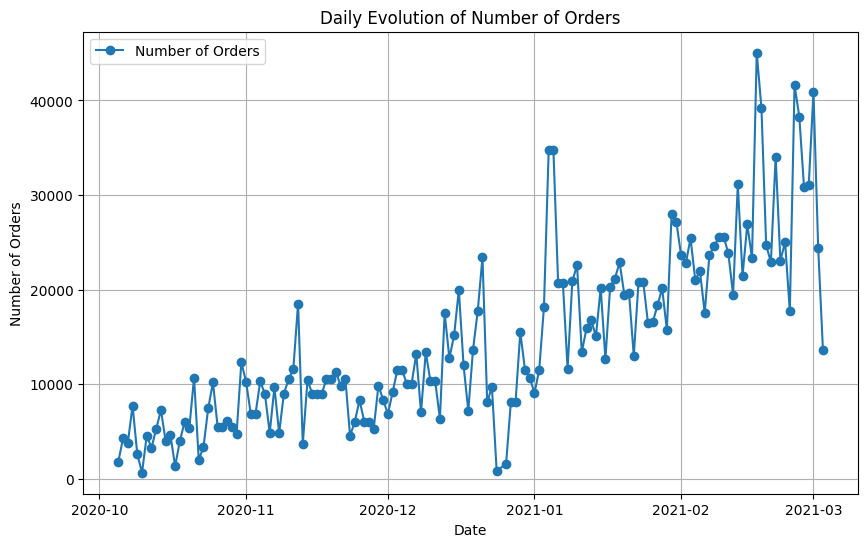

In [11]:
def order_evolution(df):
    daily_orders = df.groupby('order_date').size().reset_index(name='order_count')

    plt.figure(figsize=(10, 6))
    plt.plot(daily_orders['order_date'], daily_orders['order_count'], label='Number of Orders', marker='o')
    plt.xlabel('Date')
    plt.ylabel('Number of Orders')
    plt.title('Daily Evolution of Number of Orders')
    plt.legend()
    plt.grid(True)
    plt.show()
    
order_evolution(df=data)

In addition to applying a temporal split, we will also implement cross-validation. Cross-validation in a time series can be challenging because it's easy to shuffle data from different time points, leading to the model memorizing future behavior patterns. Additionally, we want to treat each customer's orders as a single block.

To address this, we've chosen to use the TimeSeriesSplit library from Sklearn. This library creates temporal train-test windows without mixing the sub-splits. It's important to maintain data stratification due to the imbalance in the outcome variable. However, if the imbalance remains constant over time, and given the large amount of data we have, we can consider omitting stratification.

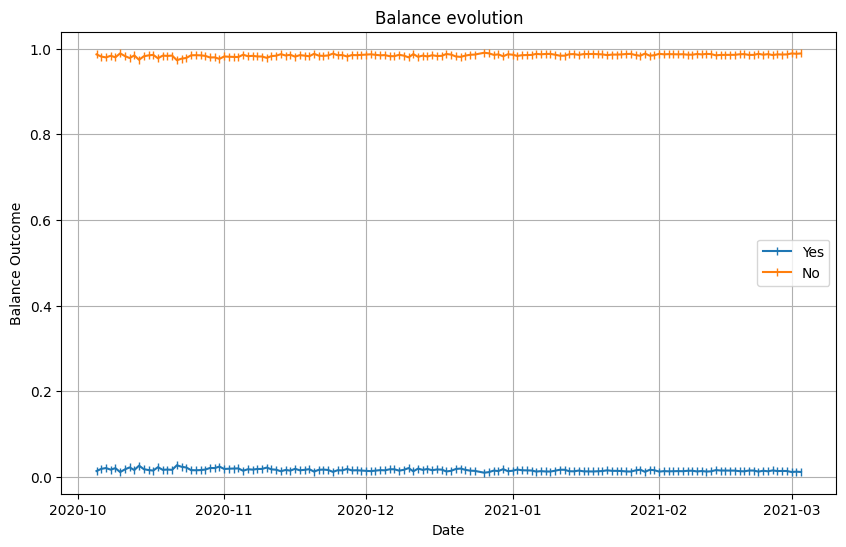

In [8]:
def balance_evolution(data):
    daily_stats = data.groupby('order_date')['outcome'].mean()
    daily_stats = daily_stats.rename_axis('Date').reset_index()
    daily_stats['not_sold'] = 1 - daily_stats['outcome']

    plt.figure(figsize=(10, 6))
    plt.plot(daily_stats['Date'], daily_stats['outcome'], label='Yes', marker='|')
    plt.plot(daily_stats['Date'], daily_stats['not_sold'], label='No', marker='|')

    plt.xlabel('Date')
    plt.ylabel('Balance Outcome')
    plt.title('Balance evolution')
    plt.legend()
    plt.grid(True)
    plt.show()
    
balance_evolution(data=data)

We've confirmed that the imbalance remains constant over time. This is primarily because the dataframe is constructed using all items from the inventory in each order.

Finally, we will check the evolution of global popularity. If we observe a clear upward trend in most products, the variable could introduce leakage that we want to avoid in our model.

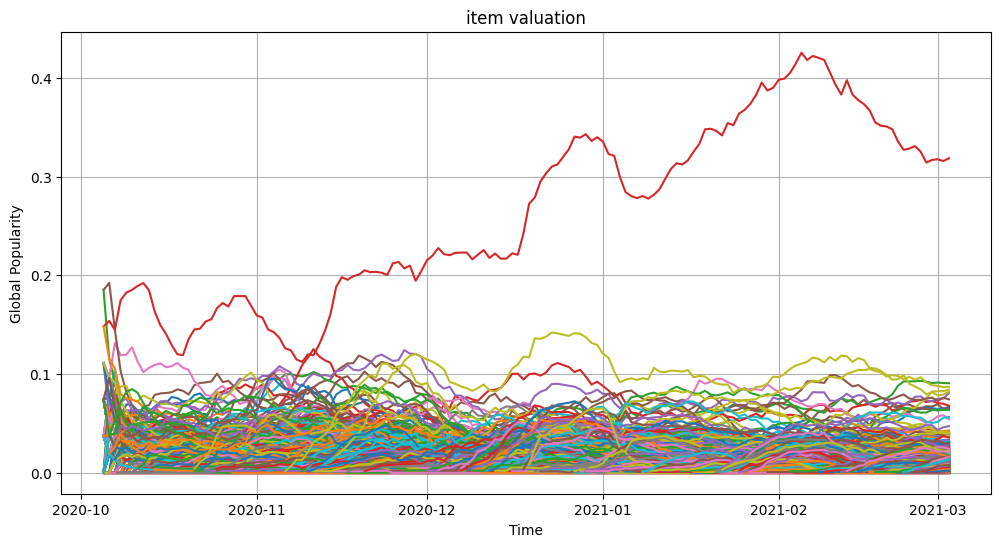

In [9]:
def plot_item_evolution(data):
    grouped_data = data.groupby(['variant_id', 'order_date'])['global_popularity'].mean().reset_index()
    pivoted_data = grouped_data.pivot(index='order_date', columns='variant_id', values='global_popularity')
    plt.figure(figsize=(12, 6))  # Tamaño del gráfico
    for column in pivoted_data.columns:
        plt.plot(pivoted_data.index, pivoted_data[column], label=column)

    plt.xlabel('Time')
    plt.ylabel('Global Popularity')
    plt.title('item valuation')
    plt.grid(True)
    plt.show()
plot_item_evolution(data)

In [12]:
def find_item_with_highest_popularity(data):
    data['global_popularity'] = pd.to_numeric(data['global_popularity'], errors='coerce')
    item_avg_popularity = data.groupby('variant_id')['global_popularity'].mean()
    item_con_valoracion_mas_alta = item_avg_popularity.idxmax()
    valoracion_mas_alta = item_avg_popularity.max()
    return item_con_valoracion_mas_alta, valoracion_mas_alta

item, popularity = find_item_with_highest_popularity(data)
print(f"Most popular items is '{item}' (oat-milk,vegan from oatly Vendor) with {popularity:.2} avg socre")

Most popular items is '34081589887108' (oat-milk,vegan from oatly Vendor) with 0.29 avg socre


We've observed that, except for a few products (like oat milk), the ratings remain constant over time. Since both this variable and the "ordered before" variable played a significant role in the models from the previous module, we'll keep them in the initial model tests.

# Preprocessing

We'll maintain the preprocessing steps applied in the previous module, as they were derived from inferences made during the exploratory data analysis. We will perform frequency encoding and scaling before the split, even though this may introduce data leakage between partitions because it's done on the entire dataset and not on each partition. However, it will make the temporal cross-validation process more manageable. Key points:

- Scaling, Removing counts, std varaibles, dummy 'product_type', frecuency 'vendor', day/year/month/day_of_year from 'ordered_date'

In [3]:
def discretize_variable(df: pd.DataFrame, labels: list, variable: str) -> pd.DataFrame:
    discretizer = KBinsDiscretizer(n_bins=4, encode="ordinal", strategy="quantile")
    df[variable] = discretizer.fit_transform(df[[variable]])
    df[variable] = df[variable].apply(lambda x: labels[int(x)])
    return df

def encoder(df: pd.DataFrame, var: str) -> pd.DataFrame:
    encoder = OneHotEncoder(
        sparse=False,
        dtype=int,
        categories="auto",
        handle_unknown="ignore",
        max_categories=10,
    )
    product_type_encoded = encoder.fit_transform(df[[var]])
    categories = encoder.get_feature_names_out()
    product_type_df = pd.DataFrame(
        product_type_encoded, columns=categories
    )  # .reset_index(drop=True, inplace=True)
    product_type_df.index = df.index
    encoded_df = pd.concat([df.drop(var, axis=1), product_type_df], axis=1)
    return encoded_df

def frequency_encoding(dataframe: pd.DataFrame, column_name:str) -> pd.DataFrame:
    frequencies = dataframe[column_name].value_counts(normalize=True)
    dataframe[column_name + "_encoded"] = dataframe[column_name].map(frequencies)
    dataframe = dataframe.drop([column_name], axis=1)
    return dataframe

def scaler(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe = frequency_encoding(dataframe, "vendor")
    sc = StandardScaler()
    dataframe = sc.fit_transform(dataframe)
    return dataframe

In [5]:
def preproccesig(df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    df = df.drop(
        [
            "count_adults",
            "count_children",
            "count_pets",
            "std_days_to_buy_variant_id",
            "std_days_to_buy_product_type",
            "created_at",
        ] + ides,
        axis=1,
    )
    df["year"] = df["order_date"].dt.year
    df["month"] = df["order_date"].dt.month
    df["day_of_year"] = df["order_date"].dt.day_of_year
    df = df.drop(["order_date"], axis=1)
    df_encoded = encoder(df=df, var="product_type")
    labels = ["Weekly", "Monthly", "Yearly", "Long_dur"]
    discretized_df = discretize_variable(
        df=df_encoded, labels=labels, variable="avg_days_to_buy_variant_id"
    )
    df_features = encoder(df=discretized_df, var="avg_days_to_buy_variant_id")
    X = df_features.drop(columns="outcome")
    cols = X.columns
    y = df_features["outcome"]
    X = scaler(dataframe=X)
    return X, y, list(cols)

X, y, cols = preproccesig(df=data)

/home/ramon/Zrive/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/ramon/Zrive/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Spliting

This time, in addition to the temporal split, we will incorporate temporal cross-validation using TimeSeriesSplit. We have chosen to create three partitions because in the sales evolution graph, we can observe three distinct temporal windows: before 10k sales, between 10k-20k sales, and after 20k sales. This approach will allow us to build a model that is agnostic to changes in customer behavior. However, based on the conclusions from Module 2, we know that customers, apart from their geographical dimension, are relatively consistent over time. This is especially true given that the family description variables have been imputed with frequent values, which isolates potential variability related to family types.

In [5]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 3)
# splits = {'train': [], 'test': []}
for i, (train_index, test_index) in enumerate(tss.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    # splits['train'].append(df.iloc[list(train_index), :])
    # splits['test'].append(df.iloc[list(test_index), :])

Fold 0:
  Train: index=[     0      1      2 ... 540986 540987 540988]
  Test:  index=[ 540989  540990  540991 ... 1081974 1081975 1081976]
Fold 1:
  Train: index=[      0       1       2 ... 1081974 1081975 1081976]
  Test:  index=[1081977 1081978 1081979 ... 1622962 1622963 1622964]
Fold 2:
  Train: index=[      0       1       2 ... 1622962 1622963 1622964]
  Test:  index=[1622965 1622966 1622967 ... 2163950 2163951 2163952]


This partitioning method indeed complicates model performance evaluation in a single validation partition to compare models and remove those showing overfitting early in the process. On the other hand, it refines the model by averaging the results from three different train splits.

# Models

In the previous module, we observed that logistic regression with hyperparameters: c=0.1 and L1 regularization significantly outperformed the baseline. In this module, we will compare the non-linear models with logistic regression. We expect minimal changes in the logistic regression results due to the preprocessing changes.

In [ ]:
dict_classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(solver= "saga"),
    "Nearest Neighbors": KNeighborsClassifier(),
}

params = {
    "Random Forest": {"n_estimators": [50,100]},
    "Logistic Regression": {'penalty': ['l1'], 'C': [0.01]},
    "Nearest Neighbors": {'n_neighbors': [5, 20], 'weights': ['distance'], 'metric': ['euclidean']},
}

for classifier_name in dict_classifiers.keys() & params:
    gridSearch = GridSearchCV(
        estimator=dict_classifiers[classifier_name], param_grid=params[classifier_name], cv=tss)
    gridSearch.fit(X, y) 
    joblib.dump(gridSearch, f"models/{classifier_name}best.pkl")

After 170 minutes of training, we obtained the best hyperparameters and the average scoring results for the various temporal partitions of X. They all appear to be suspiciously very good. For now, we know that the models are significantly better than random classification.

In [4]:
#load your model for further usage
lr = joblib.load("models/Logistic Regressionbest.pkl")
print(f'Logistic Regression: {lr.best_params_}, mean score: {lr.cv_results_["mean_test_score"][0]:.4f}')

KNN = joblib.load("models/Nearest Neighborsbest.pkl")
print(f'Nearest Neighbors: {KNN.best_params_}, mean score: {KNN.cv_results_["mean_test_score"][1]:.4f}')

rf = joblib.load("models/Random Forestbest.pkl")
print(f'Random Forest: {rf.best_params_}, mean score: {rf.cv_results_["mean_test_score"][1]:.4f}')

Logistic Regression: {'C': 0.01, 'penalty': 'l1'}, mean score: 0.9899
Nearest Neighbors: {'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'distance'}, mean score: 0.9899
Random Forest: {'n_estimators': 100}, mean score: 0.9900


We can examine the estimated parameters of the only parametric model, logistic regression. Since the dataset is scaled, we can compare their absolute values. We can see that the features that positively contribute to product purchase are "ordered_before" and "vendor" (the interpretability of "vendor" is somewhat unclear due to the encoding method used). The features that have an inverse relationship with product purchase are the normalized price and whether the product is of type "Haircare." The latter does not seem to have a logical connection with the business, as after the exploratory data analysis, it was determined that the store specialized in eco/bio brands for which customers were willing to pay a premium.

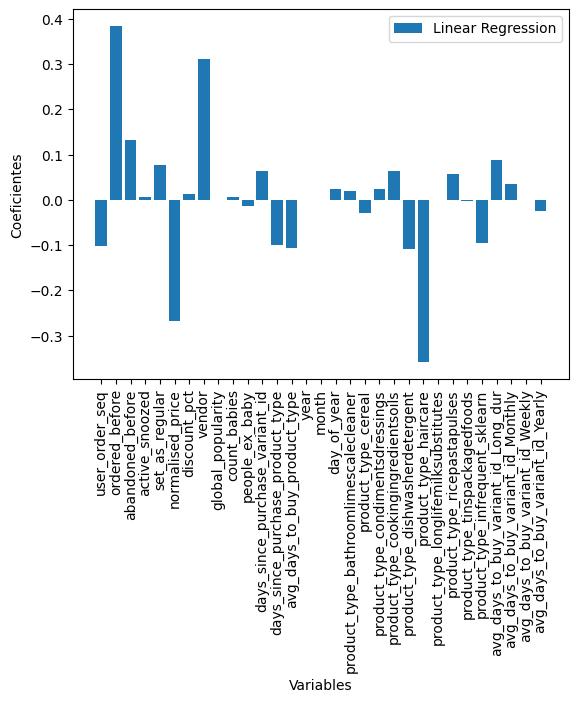

In [46]:
lr_coefs = lr.best_estimator_.coef_[0]
def plot_coefficients(coefs, labels, model_name):
    x = np.arange(len(coefs))
    plt.bar(x, coefs, label=model_name)
    plt.xticks(x, labels, rotation=90)
    
    plt.xlabel('Variables')
    plt.ylabel('Coeficientes')
    plt.legend()

plot_coefficients(lr_coefs, cols, 'Linear Regression')
plt.show()

## AUC

Now, we will visualize the ROC and Precision curves for the models on the entire dataset.

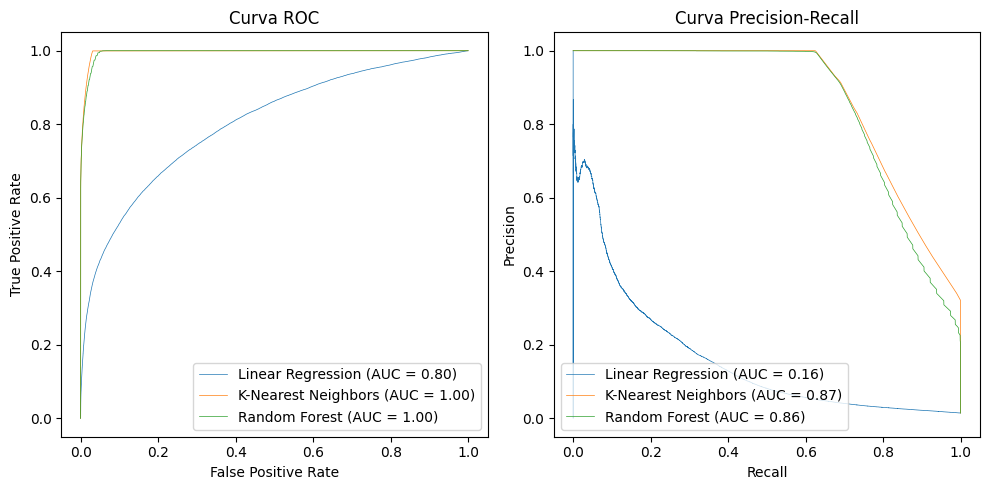

In [52]:
# Supongamos que tienes las predicciones y etiquetas verdaderas para los tres modelos
y_pred_proba_lr = lr.best_estimator_.predict_proba(X)[:, 1]
y_pred_proba_knn = KNN.best_estimator_.predict_proba(X)[:, 1]
y_pred_proba_rf = rf.best_estimator_.predict_proba(X)[:, 1]

y_true = y

# ROC
fpr_lr, tpr_lr, _ = roc_curve(y_true, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_knn, tpr_knn, _ = roc_curve(y_true, y_pred_proba_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

fpr_rf, tpr_rf, _ = roc_curve(y_true, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# precisión-recall
precision_lr, recall_lr, _ = precision_recall_curve(y_true, y_pred_proba_lr)
pr_auc_lr = auc(recall_lr, precision_lr)

precision_knn, recall_knn, _ = precision_recall_curve(y_true, y_pred_proba_knn)
pr_auc_knn = auc(recall_knn, precision_knn)

precision_rf, recall_rf, _ = precision_recall_curve(y_true, y_pred_proba_rf)
pr_auc_rf = auc(recall_rf, precision_rf)

# Gráficos de curvas ROC
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr_lr, tpr_lr, lw=0.5, label=f"Linear Regression (AUC = {roc_auc_lr:.2f})")
plt.plot(fpr_knn, tpr_knn, lw=0.5, label=f"K-Nearest Neighbors (AUC = {roc_auc_knn:.2f})")
plt.plot(fpr_rf, tpr_rf, lw=0.5, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')

# Gráficos de curvas de precisión-recall
plt.subplot(1, 2, 2)
plt.plot(recall_lr, precision_lr, lw=0.5, label=f"Linear Regression (AUC = {pr_auc_lr:.2f})")
plt.plot(recall_knn, precision_knn, lw=0.5, label=f"K-Nearest Neighbors (AUC = {pr_auc_knn:.2f})")
plt.plot(recall_rf, precision_rf, lw=0.5, label=f"Random Forest (AUC = {pr_auc_rf:.2f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

When conducting a temporal cross-validation process, we could have chosen to draw the curves over any of the three partitions. However, as the process returns the best hyperparameters in a "partition-agnostic" manner, we decided to visualize them as if they were final results.

We can see that the logistic model is slightly different from the one obtained in the previous module (along with its estimated parameters). This difference can be attributed to the slight preprocessing variations and the different partitioning technique used (the AUC drops by 0.3 points). The KNN and Random Forest models seem extremely accurate and show little trade-off when predicting classes, making errors almost negligible.

In theory, we know that a Random Forest should achieve a perfect score when trained on the training set. The same applies to KNN with such a low neighborhood parameter, such as 20 (relative to the number of data points, as 20 out of the millions of records we have forms too many neighborhoods, potentially leading to overfitting). The model aligns with theory, but without more data, we won't be able to verify the accuracy of the results until implementation in production. It's essential to conduct thorough testing in a real-world environment to confirm the model's effectiveness and generalizability.

To be honest, there is a level of skepticism about the results, and it's assumed that some degree of overfitting has occurred. Part of the overfitting may be manual, as a result of attempting to fine-tune each split with a wide range of models and hyperparameters. Part of it may be due to the information leakage mentioned in Vendor/Ordered Before (a very important feature, by the way)/Global popularity. What seems certain is that control over the training process has been somewhat lost. The temporal cross-validation (captured by the "cv" parameter of GridSearchCV) doesn't appear to have worked as expected. Although the results for each model .pkl indicate that three splits were made, and each combination of hyperparameters/models was used in each of the three splits. Indeed, if the models do not have overfitting, they would be considered ideal, but we need more data. Due to the very long training times, it's not feasible to replicate the process on a smaller scale. One approach could involve optimizing the models (making them smoother), removing variables, or excluding the KNN model, which takes the longest to train. It would have been good practice to reserve a small portion of the original dataset for testing overfitting, beyond the applied cross-validation partitions.

# Extra

Since we cannot asure the performance of the previous models, we will repeat the process, this time focusing on keeping it simple.

On preprocessing we wont keep categorical varaibals, thus not having to encode them. We will add only one additional data vriables, day_of_year, since the others were not performing well (regularization). We will drop the variables that clearly caused information leakage. Depending on how the model performs, we can consider including them again (especially if "ordered_before" was relevant).

In [12]:
def scaler_extra(dataframe: pd.DataFrame) -> pd.DataFrame:
    sc = StandardScaler()
    dataframe = sc.fit_transform(dataframe)
    return dataframe

def preproccesig_extra(df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    df = df.drop(
        [
            "count_adults",
            "count_children",
            "count_pets",
            "std_days_to_buy_variant_id",
            "std_days_to_buy_product_type",
            "created_at",
            "ordered_before",
            "global_popularity"
        ] + ides + categrorical,
        axis=1,
    )
    df["day_of_year"] = df["order_date"].dt.day_of_year
    df = df.sort_values(by='order_date')
    df_train = df[df['order_date'] < '2021-02-01'].drop(['order_date'], axis=1)
    df_val = df[(df['order_date'] >= '2021-02-01') & (df['order_date'] <= '2021-02-20')].drop(['order_date'], axis=1)
    df_test = df[df['order_date'] > '2021-02-20'].drop(['order_date'], axis=1)

    return df_train, df_val, df_test

df_train, df_val, df_test = preproccesig_extra(df=data)

cols = df_train.columns
X_train = scaler_extra(df_train.drop(columns="outcome"))
y_train = df_train["outcome"]
X_val = scaler_extra(df_val.drop(columns="outcome"))
y_val = df_val["outcome"]
X_test = scaler_extra(df_test.drop(columns="outcome"))
y_test = df_test["outcome"]

In [ ]:
N_CORES = joblib.cpu_count(only_physical_cores=True)
RandmForest = RandomForestClassifier(n_estimators = 100,verbose=3,random_state=0, n_jobs=N_CORES)
RandmForest.fit(X_train, y_train)
joblib.dump(RandmForest, f"models/RandmForest_extrabest.pkl")

LogReg = LogisticRegression(solver= "saga", penalty='l1', C=0.01)
LogReg.fit(X_train, y_train)
joblib.dump(LogReg, f"models/LogReg_extrabest.pkl")

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.3s finished


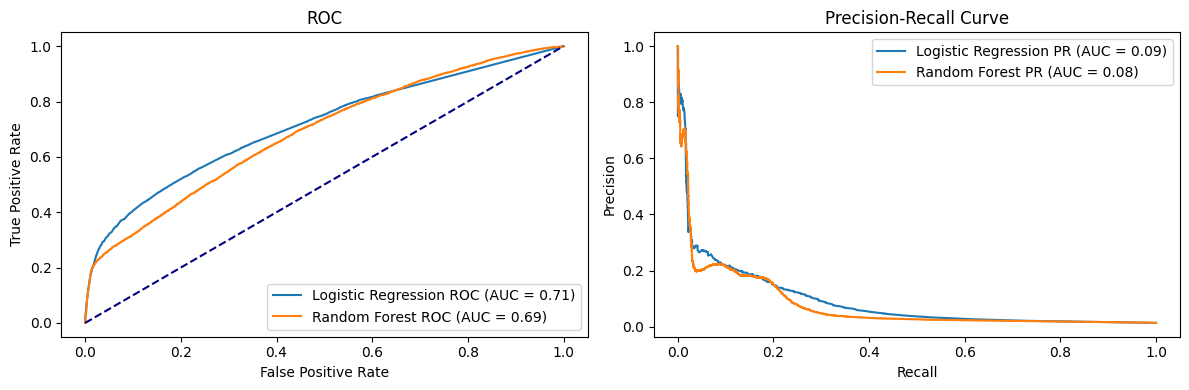

In [18]:
y_pred_prob_rf = RandmForest.predict_proba(X_val)[:, 1]
y_pred_prob_lr = LogReg.predict_proba(X_val)[:, 1]

fpr1, tpr1, _ = roc_curve(y_val, y_pred_prob_rf)
precision1, recall1, _ = precision_recall_curve(y_val, y_pred_prob_rf)

fpr2, tpr2, _ = roc_curve(y_val, y_pred_prob_lr)
precision2, recall2, _ = precision_recall_curve(y_val, y_pred_prob_lr)

plt.figure(figsize=(12, 4))

# Curva ROC
plt.subplot(1, 2, 1)
plt.plot(fpr1, tpr1, label=f'Logistic Regression ROC (AUC = {auc(fpr1, tpr1):.2f})')
plt.plot(fpr2, tpr2, label=f'Random Forest ROC (AUC = {auc(fpr2, tpr2):.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

# Curva de precisión-recall
plt.subplot(1, 2, 2)
plt.plot(recall1, precision1, label=f'Logistic Regression PR (AUC = {auc(recall1, precision1):.2f})')
plt.plot(recall2, precision2, label=f'Random Forest PR (AUC = {auc(recall2, precision2):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

What we gain in versatility and execution speed, we seem to lose in model precision. A random forest with 100 trees is unable to outperform the baseline (linear regression). The split appears to make the model less effective at making predictions, but it seems to generalize better to different datasets. The validation and test AUC metrics may decrease, but relatively less than a model that is overfitted.

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.4s finished


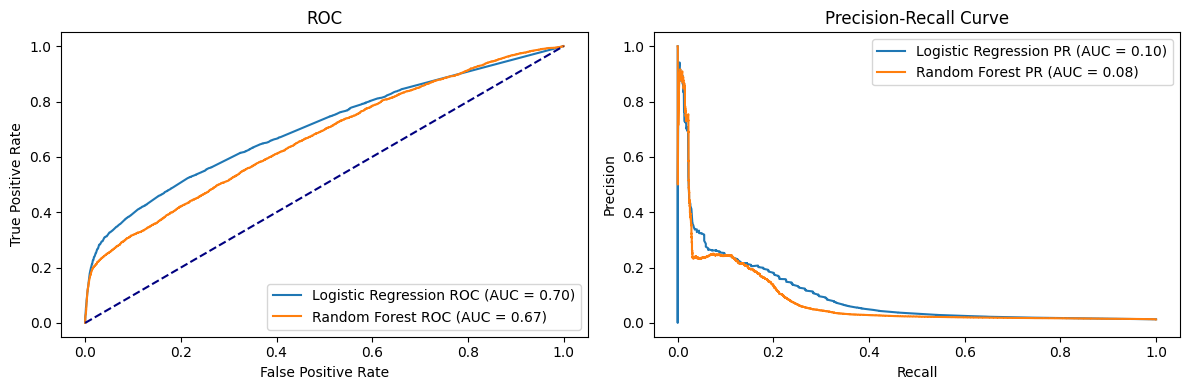

In [30]:
y_pred_prob_rf = RandmForest.predict_proba(X_test)[:, 1]
y_pred_prob_lr = LogReg.predict_proba(X_test)[:, 1]

fpr1, tpr1, _ = roc_curve(y_test, y_pred_prob_rf)
precision1, recall1, _ = precision_recall_curve(y_test, y_pred_prob_rf)

fpr2, tpr2, _ = roc_curve(y_test, y_pred_prob_lr)
precision2, recall2, _ = precision_recall_curve(y_test, y_pred_prob_lr)

plt.figure(figsize=(12, 4))

# Curva ROC
plt.subplot(1, 2, 1)
plt.plot(fpr1, tpr1, label=f'Logistic Regression ROC (AUC = {auc(fpr1, tpr1):.2f})')
plt.plot(fpr2, tpr2, label=f'Random Forest ROC (AUC = {auc(fpr2, tpr2):.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

# Curva de precisión-recall
plt.subplot(1, 2, 2)
plt.plot(recall1, precision1, label=f'Logistic Regression PR (AUC = {auc(recall1, precision1):.2f})')
plt.plot(recall2, precision2, label=f'Random Forest PR (AUC = {auc(recall2, precision2):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

## Prev Preprocessing

We will build the same models one last time with the initial preprocessing and keep "global_popularity" (but with this split method). It appears that the importance of these variables is crucial for the model's accuracy, even though it may introduce information leakage.

In [4]:
def preproccesig_extra2(df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    df = df.drop(
        [
            "count_adults",
            "count_children",
            "count_pets",
            "std_days_to_buy_variant_id",
            "std_days_to_buy_product_type",
            "created_at",
        ] + ides,
        axis=1,
    )
    df["year"] = df["order_date"].dt.year
    df["month"] = df["order_date"].dt.month
    df["day_of_year"] = df["order_date"].dt.day_of_year
    df_encoded = encoder(df=df, var="product_type")
    labels = ["Weekly", "Monthly", "Yearly", "Long_dur"]
    discretized_df = discretize_variable(
        df=df_encoded, labels=labels, variable="avg_days_to_buy_variant_id"
    )
    df_features = encoder(df=discretized_df, var="avg_days_to_buy_variant_id")
    df_train = df_features[df_features['order_date'] < '2021-02-01'].drop(['order_date'], axis=1)
    df_val = df_features[(df_features['order_date'] >= '2021-02-01') & (df['order_date'] <= '2021-02-20')].drop(['order_date'], axis=1)
    df_test = df_features[df_features['order_date'] > '2021-02-20'].drop(['order_date'], axis=1)
    return df_train, df_val, df_test

df_train, df_val, df_test = preproccesig_extra2(df=data)

cols = df_train.columns
X_train = scaler(df_train.drop(columns="outcome"))
y_train = df_train["outcome"]

X_val = scaler(df_val.drop(columns="outcome"))
y_val = df_val["outcome"]

X_test = scaler(df_test.drop(columns="outcome"))
y_test = df_test["outcome"]

/home/ramon/Zrive/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/ramon/Zrive/zrive-ds/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
N_CORES = joblib.cpu_count(only_physical_cores=True)
RandmForest = RandomForestClassifier(n_estimators = 100,verbose=3,random_state=0, n_jobs=N_CORES)
RandmForest.fit(X_train, y_train)

LogReg = LogisticRegression(solver= "saga", penalty='l1', C=0.01)
LogReg.fit(X_train, y_train)


In [ ]:
joblib.dump(RandmForest, f"models/RandmForest_extra2.pkl")
joblib.dump(LogReg, f"models/LogReg_extra2.pkl")

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.3s finished


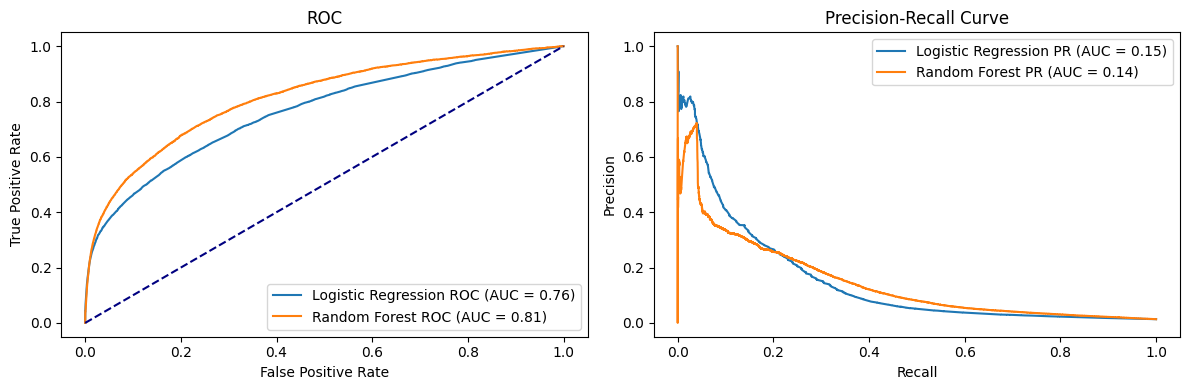

In [6]:
y_pred_prob_rf = RandmForest.predict_proba(X_val)[:, 1]
y_pred_prob_lr = LogReg.predict_proba(X_val)[:, 1]

fpr1, tpr1, _ = roc_curve(y_val, y_pred_prob_rf)
precision1, recall1, _ = precision_recall_curve(y_val, y_pred_prob_rf)

fpr2, tpr2, _ = roc_curve(y_val, y_pred_prob_lr)
precision2, recall2, _ = precision_recall_curve(y_val, y_pred_prob_lr)

plt.figure(figsize=(12, 4))

# Curva ROC
plt.subplot(1, 2, 1)
plt.plot(fpr1, tpr1, label=f'Logistic Regression ROC (AUC = {auc(fpr1, tpr1):.2f})')
plt.plot(fpr2, tpr2, label=f'Random Forest ROC (AUC = {auc(fpr2, tpr2):.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

# Curva de precisión-recall
plt.subplot(1, 2, 2)
plt.plot(recall1, precision1, label=f'Logistic Regression PR (AUC = {auc(recall1, precision1):.2f})')
plt.plot(recall2, precision2, label=f'Random Forest PR (AUC = {auc(recall2, precision2):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.1s finished


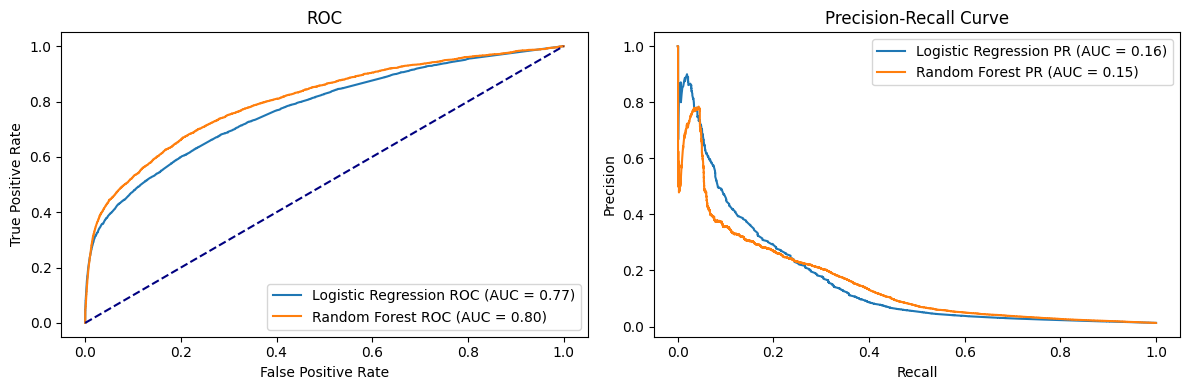

In [12]:
y_pred_prob_rf = RandmForest.predict_proba(X_test)[:, 1]
y_pred_prob_lr = LogReg.predict_proba(X_test)[:, 1]

fpr1, tpr1, _ = roc_curve(y_test, y_pred_prob_rf)
precision1, recall1, _ = precision_recall_curve(y_test, y_pred_prob_rf)

fpr2, tpr2, _ = roc_curve(y_test, y_pred_prob_lr)
precision2, recall2, _ = precision_recall_curve(y_test, y_pred_prob_lr)

plt.figure(figsize=(12, 4))

# Curva ROC
plt.subplot(1, 2, 1)
plt.plot(fpr1, tpr1, label=f'Logistic Regression ROC (AUC = {auc(fpr1, tpr1):.2f})')
plt.plot(fpr2, tpr2, label=f'Random Forest ROC (AUC = {auc(fpr2, tpr2):.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

# Curva de precisión-recall
plt.subplot(1, 2, 2)
plt.plot(recall1, precision1, label=f'Logistic Regression PR (AUC = {auc(recall1, precision1):.2f})')
plt.plot(recall2, precision2, label=f'Random Forest PR (AUC = {auc(recall2, precision2):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

Much better. *For test split we get better results than validation split*. Now we have a model that is scalable for further hyperparameter optimization, and we have a roadmap for preprocessing that, despite some leakages (which have now been resolved for frequency encoding and scaling), improves upon the baseline.

The issue with Random Forest lies in its accuracy when determining whether a user will purchase the product or not, especially due to class imbalance. To improve the Random Forest model's performance (compared to LogReg), you would have to sacrifice a lot of recall to gain precision, and even then, it may not be better than the baseline. In the previous module, a stratified split was used, and the LogReg model was more precise than with a temporal split. Balancing precision and recall can be a challenging task, and it often depends on the specific problem and dataset. Further hyperparameter tuning and experimenting with different techniques could potentially lead to better results for Random Forest.

# Calibration
*valuation results*

In [7]:
lr_prob_true, lr_prob_pred = calibration_curve(y_val, y_pred_prob_lr, n_bins=20)
rf_prob_true, rf_prob_pred = calibration_curve(y_val, y_pred_prob_rf, n_bins=20)

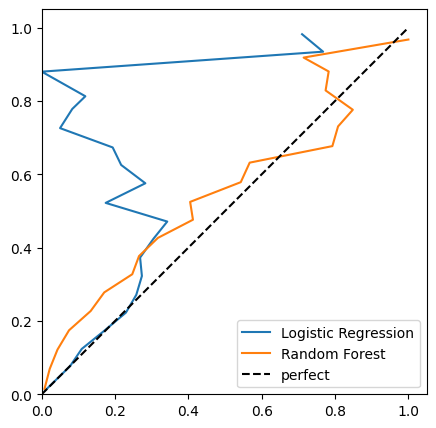

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(lr_prob_true, lr_prob_pred, label=f'Logistic Regression')
ax.plot(rf_prob_true, rf_prob_pred, label=f'Random Forest')
ax.plot([0,1], [0,1], color = 'k', linestyle ='--', label = 'perfect')
ax.set_ylim([0,1.05])
ax.set_xlim([0,1.05])
ax.set_aspect('equal', 'box')
ax.legend()

Random Forest much more better calibrated

In [14]:
calibrated_LR = CalibratedClassifierCV(LogReg, cv='prefit', method='isotonic')
calibrated_RF = CalibratedClassifierCV(RandmForest, cv='prefit', method='isotonic')

In [ ]:
calibrated_LR.fit(X_val, y_val)
calibrated_RF.fit(X_val, y_val)

y_pred_prob_rf_calibrated = calibrated_RF.predict_proba(X_val)[:, 1]
y_pred_prob_lr_calibrated = calibrated_RF.predict_proba(X_val)[:, 1]

lr_prob_true, lr_prob_pred = calibration_curve(y_val, y_pred_prob_rf_calibrated, n_bins=20)
rf_prob_true, rf_prob_pred = calibration_curve(y_val, y_pred_prob_lr_calibrated, n_bins=20)

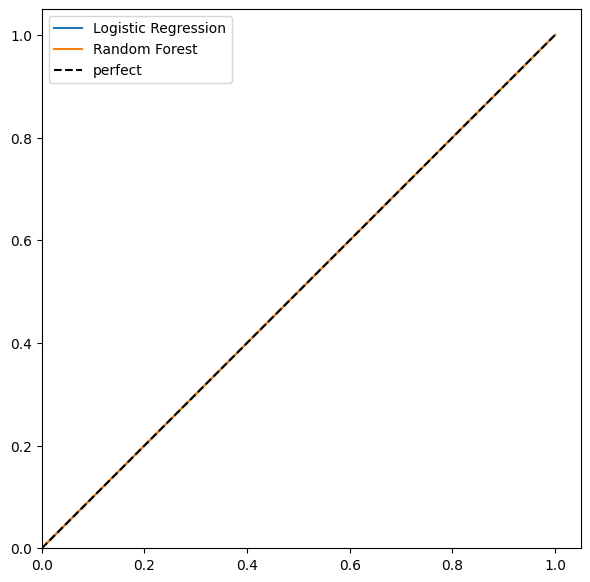

In [16]:
fi, ax  = plt.subplots(figsize = (7,7))
ax.plot(lr_prob_true, lr_prob_pred, label=f'Logistic Regression')
ax.plot(rf_prob_true, rf_prob_pred, label=f'Random Forest')
ax.plot([0,1], [0,1], color = 'k', linestyle ='--', label = 'perfect')
ax.set_ylim([0,1.05])
ax.set_xlim([0,1.05])
ax.set_aspect('equal', 'box')
ax.legend()

# Conclusion:

We've observed that certain variables are crucial for the model, despite some information leakage. The leakage from frequency encoding and scaling has a more significant impact than expected.

In general, logistic regression is a more accessible model when the project requires quick execution times. If we can invest time in optimizing hyperparameters during training, we can consider Random Forest (or KNN, though it's very slow).

The choice of the split is crucial. If detecting changes in user behavior patterns is vital for the business, we should not abandon the temporal split. The temporal leakage from a stratified split leads to a better-predicting model (but theoretically, it's constructed incorrectly).